In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [3]:
#uncomment this decorator to test your code
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x_old, y_old, thetha_old = curr_pose[0], curr_pose[1], curr_pose[2]
    x = x_old + v * np.cos(thetha_old) *dt
    y = y_old + v * np.sin(thetha_old) *dt
    w = v * np.tan(delta)/0.9 #L=0.9
    theta = thetha_old + w* dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return (x, y, theta)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/doctest.py", line 1487, in run
    sys.settrace(save_trace)



Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 7, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.11)
**********************************************************************
File "__main__", line 9, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expected:
    (1.0, 0.0, 1.11)
Got:
    (1.0, 0.0, 1.111111111111111)


In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
v = 1.0
delta = 0
for _ in range(steps):
   #instruction to take v, w and compute new pose    
   pose = bicycle_model(pose, v,delta)
   # store new pose
   straight_trajectory.append(list(pose))
straight_trajectory = np.array(straight_trajectory)

In [5]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 22
#fill in v and omega values
v = 1.0
delta = np.pi/12
for _ in range(steps):
    #instruction to take v, w and compute new pose    
    pose = bicycle_model(pose, v,delta)
    # store new pose
    circle_trajectory.append(list(pose))
circle_trajectory = np.array(circle_trajectory)

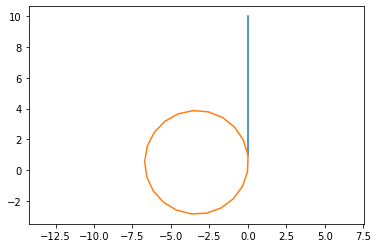

In [6]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1])
plt.show()

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [7]:
v_c = 1 # m/s
delta_c = np.pi/12 # rad/s
L=0.9
w_c = v_c * np.tan(delta_c)/L
#calculate time taken to finish a quarter turn (pi/4)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn =  int((np.pi/2) / w_c )

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c) , int(5/v_c) , int(8/v_c)

all_delta = [0]*t_straight1 + [delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [8]:
from math import ceil
def get_open_loop_commands(route, vc, deltac, dt=1):
    all_delta = []
    all_v = []
    L = 0.9
    wc = vc * np.tan(deltac)/L
    for (dir,amt) in route:
        if dir == "straight":
            t_straight = ceil((amt/vc)/dt)
            all_delta += [0]*t_straight
        else:
            amt = (amt/180) * np.pi #Considering that the turn amount in the controls is given in degrees.
            t_turn = ceil((amt/wc)/dt)
            if dir == "right":
                all_delta += [-deltac]*t_turn
            elif dir == "left":
                all_delta += [deltac]*t_turn
    all_v = vc*np.ones_like(all_delta)
    # return all_v, all_w
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [9]:
#get_open_loop_commands()
cmd = [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
vc = 1
deltac = np.pi/12
all_v, all_delta = get_open_loop_commands(cmd,vc,deltac)

In [10]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta):
    #instruction to take v, w and compute new pose    
    pose = bicycle_model(pose, v,delta)
    # store new pose
    robot_trajectory.append(list(pose))
robot_trajectory = np.array(robot_trajectory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


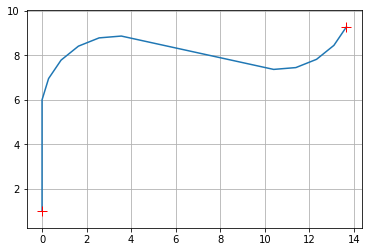

In [11]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1])
#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
plt.plot(robot_trajectory[0,0],robot_trajectory[0,1], 'r+', ms=10)
plt.plot(robot_trajectory[-1,0],robot_trajectory[-1,1], 'r+', ms=10)


### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [12]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

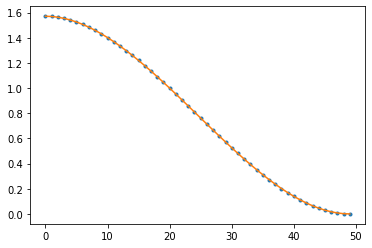

In [13]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0,50),'.')
plt.plot(poly_turn(np.pi/2, 0,50))

Now plot a left turn (North to West)

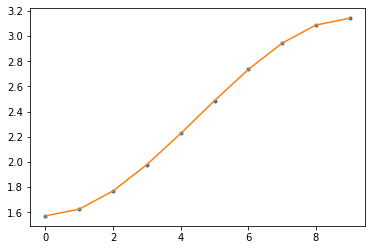

In [14]:
plt.figure()
plt.plot(poly_turn(np.pi/2, np.pi),'.')
plt.plot(poly_turn(np.pi/2, np.pi))

How does $\theta$ change when we had constant $\delta$? Plot it

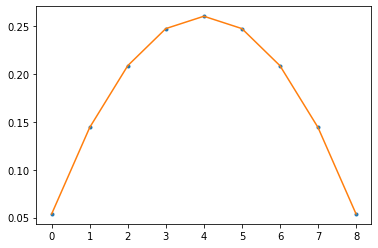

In [15]:
del_thetha = np.diff(poly_turn(np.pi/2, np.pi,10))
plt.plot(del_thetha,'.')
plt.plot(del_thetha)

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

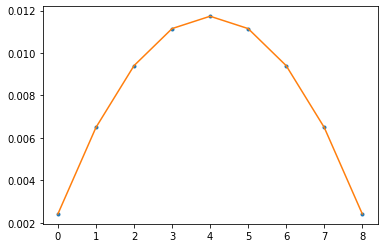

In [16]:
n = 10
# dt = 1/n
theta_i = np.pi/2
theta_f = np.pi
thetha = poly_turn(theta_i, theta_f,n)
del_thetha = np.diff(thetha)
L =0.9
v =20
delta = np.arctan(del_thetha * L /v) 
plt.plot(delta,'.')
plt.plot(delta)